# Prepare climate modes data

In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:10:00'
cores = 4
memory = str(4 * cores)
memory = memory + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.44.25:8787/status,
Dashboard: http://10.6.44.25:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.44.25:36793,Workers: 0
Dashboard: http://10.6.44.25:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [6]:
def get_plot_params():
    """
    Get the plotting parameters used for figures
    """
    FONT_SIZE = 7
    COASTLINES_LW = 0.5
    LINEWIDTH = 1.3
    PATHEFFECT_LW_ADD = LINEWIDTH * 1.8

    return {'lines.linewidth': LINEWIDTH,
            'hatch.linewidth': 0.5,
            'font.size': FONT_SIZE,
            'legend.fontsize' : FONT_SIZE - 1,
            'legend.columnspacing': 0.7,
            'legend.labelspacing' : 0.03,
            'legend.handlelength' : 1.,
            'axes.linewidth': 0.5}

plt_params = get_plot_params()

# MJO

### Adames index

1. Daily anomalies of $\chi_{150} - \chi_{850}$
2. Area weight using 
2. PCA. First two PCs and EOFs.
3. Amplitude: $\sqrt{\mathrm{PC}_{1}^{2} + \mathrm{PC}_{2}^{2}}$.
4. Phase: $\arctan\mathrm{2}(\mathrm{PC}_{2}, \mathrm{PC}_{1})$. Note the order of PCs here!
5. Check signal propagates eastwards. If it doesn't, change the sign of one of the PCs.

### Load and concat various vpot files

In [7]:
vpot_1979_2020 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/vpot/vpot_era5_daily_1979_2020_2x2_grid.zarr',
    consolidated=True
)

In [8]:
vpot_l150_2021 = xr.open_mfdataset(
    '/g/data/w42/dr6273/work/data/era5/vpot/nc/vpot_150_era5_daily_2021_2x2_grid.nc'
)

vpot_l850_2021 = xr.open_mfdataset(
    '/g/data/w42/dr6273/work/data/era5/vpot/nc/vpot_850_era5_daily_2021_2x2_grid.nc'
)

vpot_l150_2022 = xr.open_mfdataset(
    '/g/data/w42/dr6273/work/data/era5/vpot/nc/vpot_150_era5_daily_2022_2x2_grid.nc'
)

vpot_l850_2022 = xr.open_mfdataset(
    '/g/data/w42/dr6273/work/data/era5/vpot/nc/vpot_850_era5_daily_2022_2x2_grid.nc'
)

In [9]:
vpot_2021 = xr.concat(
    [
    vpot_l150_2021,
    vpot_l850_2021
    ],
    dim='level'
).rename({
    'lat': 'latitude',
    'lon': 'longitude'
})

vpot_2022 = xr.concat(
    [
    vpot_l150_2022,
    vpot_l850_2022
    ],
    dim='level'
).rename({
    'lat': 'latitude',
    'lon': 'longitude'
})

In [10]:
vpot = xr.concat([
    vpot_1979_2020,
    vpot_2021,
    vpot_2022
],
    dim='time'
)

### Choose climatology period

In [7]:
clim_period = slice('1981', '2010')

### SVD takes ~1.5 hours to compute (for two data sets - unadjusted and detrended vpot)

In [8]:
import xeof

In [13]:
def vpot_anomalise(vpot, clim_period):
    """
    Take difference of vpot data, anomalise, rechunk to single chunk
    and then write and read back in
    """
    import dask
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        print('Calculating anomalies...')
        vpot_diff = vpot.vpot.sel(level=150) - vpot.vpot.sel(level=850)
        vpot_diff = vpot_diff.chunk({'time': -1, 'latitude': 61, 'longitude': 60})
        
        vpot_clim = vpot_diff.sel(
            time=clim_period
        ).groupby(
            'time.dayofyear'
        ).mean(
            'time'
        )
        # Chunking climatology like this makes a big difference!
        vpot_clim = vpot_clim.chunk({'dayofyear': -1, 'latitude': 61, 'longitude': 60})
        
        vpot_anoms = vpot_diff.groupby('time.dayofyear') - vpot_clim

        return vpot_anoms

In [14]:
def detrend_dim(da, dim, deg=1):
    """
    Detrend along a single dimension.
    
    Author: Ryan Abernathy
    From: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
    """
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [15]:
def detrend_vpot_anoms(vpot_anoms, clim_period):
    """
    Detrend vpot, write and read back in.
    """
    print('Detrending...')
    vpot_anoms_dt = detrend_dim(vpot_anoms, 'time')
    vpot_anoms_dt.name = 'vpot'

    return vpot_anoms_dt

In [16]:
def vpot_EOF(vpot_anoms, clim_period, detrended, data_path):
    """
    PCA. vpot_anoms should be in memory as otherwise the SVD
    kills workers.
    """
    xeof.core.LAT_NAME = 'latitude'
    
    print('Computing EOFs...')
    vpot_eof = xeof.eof(vpot_anoms,
                        sensor_dims=['latitude', 'longitude'],
                        sample_dim='time',
                        weight='sqrt_cos_lat',
                        n_modes=5,
                        norm_PCs=False)
    
    print('Writing...')
    if detrended:
        fp = '/vpot_150-850_diff_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_era5_daily_2x2_grid_detrended_PCA.zarr'
    else:
        fp = '/vpot_150-850_diff_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_era5_daily_2x2_grid_PCA.zarr'
        
    vpot_eof.to_zarr(
        data_path + fp,
        mode='w',
        consolidated=True
    )
    
    return vpot_eof

In [9]:
compute = False

In [10]:
data_path = '/g/data/w42/dr6273/work/data/era5/vpot/derived/'

In [11]:
%%time
if compute:
    # VPOT anomalies. Compute this to ensure EOF goes through.
    vpot_anoms = vpot_anomalise(vpot, clim_period).compute()
    # Detrended anomalies
    vpot_anoms_dt = detrend_vpot_anoms(vpot_anoms, clim_period)
    
    client.close()
    cluster.close()
    
#     # EOFs
    vpot_eof = vpot_EOF(vpot_anoms, clim_period, detrended=False, data_path=data_path)
    vpot_eof_dt = vpot_EOF(vpot_anoms_dt, clim_period, detrended=True, data_path=data_path)
    
else:
    vpot_eof = xr.open_zarr(
        data_path + '/vpot_150-850_diff_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_era5_daily_2x2_grid_PCA.zarr',
        consolidated=True
    )
    vpot_eof_dt = xr.open_zarr(
        data_path + 'vpot_150-850_diff_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_era5_daily_2x2_grid_detrended_PCA.zarr',
        consolidated=True
    )

CPU times: user 213 ms, sys: 71.1 ms, total: 285 ms
Wall time: 432 ms


In [12]:
vpot_eof = vpot_eof.compute()

In [13]:
vpot_eof_dt = vpot_eof_dt.compute()

### Check EOFs and PCs look right

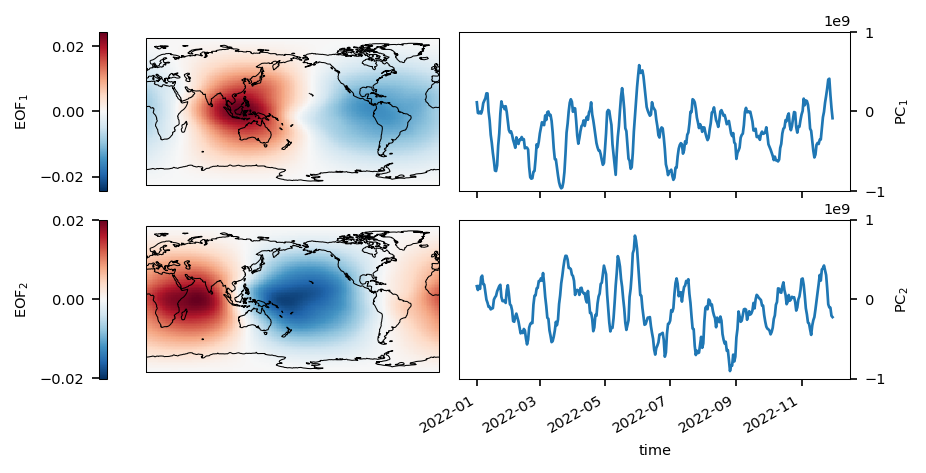

In [15]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(6.9,3), dpi=150)
    
    for mode in range(2):
        
        # EOFs
        pos = mode * 2 + 1
        ax = fig.add_subplot(2, 2, pos, projection=ccrs.PlateCarree(central_longitude=180))
        ax.coastlines(lw=0.5)
        vpot_eof.eof.sel(mode=mode+1).plot(ax=ax,
                                            transform=ccrs.PlateCarree(),
                                            cbar_kwargs={'location': 'left',
                                                         'label': r'EOF$_{'+str(mode+1)+'}$'})
        ax.set_title('')
        
        # PCs
        pos = mode * 2 + 2
        ax = fig.add_subplot(2, 2, pos)
        vpot_eof.pc.sel(mode=mode+1, time='2022').plot(ax=ax)
        ax.set_ylim(-1e9, 1e9)
        ax.set_title('')
        if mode < 1:
            ax.set_xticklabels('')
            ax.set_xlabel('')
        ax.set_ylabel(r'PC$_{'+str(mode+1)+'}$')
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        
    plt.subplots_adjust(hspace=0.18, wspace=0.05)

### Amplitude $A$ and phase $\theta$

In [16]:
def calc_mjo(da, mode_1=1, mode_2=2, transform_mode_1=False, transform_mode_2=False):
    """
    Calculate the phase and amplitude of the MJO
    """
    m1 = da.sel(mode=mode_1)
    m2 = da.sel(mode=mode_2)
    
    if transform_mode_1:
        m1 = m1 * -1
    if transform_mode_2:
        m2 = m2 * -1
        
    amplitude = np.sqrt(np.square(m1) + np.square(m2))
    phase = np.arctan2(m2, m1)
    return amplitude, phase

### To propagate eastwards, we need to ensure $d\theta / dt$ is positive.

- The figure below shows that in our case it is negative, so we multiply an EOF and the corresponding PC by -1

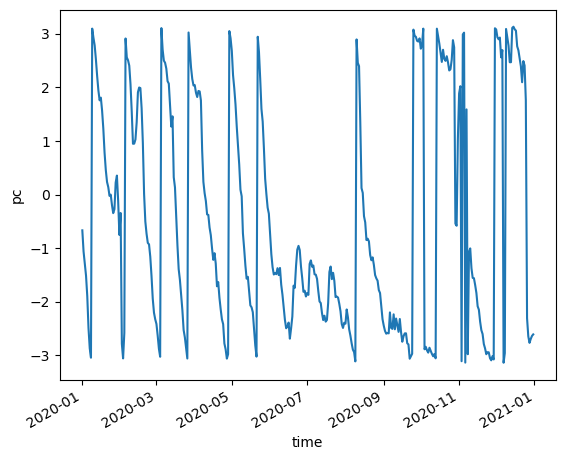

In [17]:
calc_mjo(vpot_eof.pc.sel(time='2020'))[1].plot()

### Multiply EOF 2 by -1

In [18]:
mjo_amplitude, mjo_phase = calc_mjo(vpot_eof.pc, transform_mode_2=True)

mjo = mjo_phase.to_dataset(name='phase')
mjo['amplitude'] = mjo_amplitude

In [19]:
mjo_amplitude_dt, mjo_phase_dt = calc_mjo(vpot_eof_dt.pc, transform_mode_2=True)

mjo_dt = mjo_phase_dt.to_dataset(name='phase_detrended')
mjo_dt['amplitude_detrended'] = mjo_amplitude_dt

### We also want to label the phase according to its geographical location

When the phase, arctan2(PC2, PC1), is zero, PC2 must be zero, and PC1 must be positive. From looking at EOF1, we now know that phase of zero corresponds to upper-level convergence over the Maritime Continent, and an active MJO in the western Hemisphere/Africa.

When PC2 = 0 and PC1 is negative, the phase is $\pi$ and the MJO is active over the Maritime Continent.

We label the phases from 1 to 8 following standard terminology:
1. W Hem. & Africa
2. Indian Ocean
3. Indian Ocean
4. Maritime Continent
5. Maritime Continent
6. W Pacific
7. W Pacific
8. W Hem. & Africa

In [20]:
def discretise_phase(da):
    """
    Discretise MJO phase into octants
    """
    bins = np.linspace(-np.pi, np.pi, 9) 
    phase = xr.apply_ufunc(np.digitize, da, bins, dask='allowed')
    # Relabel so that octants refer to correct phase e.g. 0 < phase < pi/4 should be labelled "1"
    phase = phase.where(phase > 4, phase + 8)
    return phase - 4

In [21]:
mjo['phase_ID'] = discretise_phase(mjo.phase)

In [51]:
mjo.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_daily_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022.nc',
    mode='w',
)

In [24]:
mjo_dt['phase_ID_detrended'] = discretise_phase(mjo_dt.phase_detrended)

In [52]:
mjo_dt.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_daily_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022_detrended.nc',
    mode='w',
)

### Check polar representation of EOFs

In [26]:
def plot_polar(eofs):
    """
    Plot MJO in polar representation
    """
    # Change lons to 0-360
    mjo_shift = eofs.copy()
    mjo_shift['longitude'] = (mjo_shift['longitude'] + 360) % 360
    mjo_shift = mjo_shift.sortby(mjo_shift['longitude'])
    
    shifted_eof_amplitude, shifted_eof_phase = calc_mjo(mjo_shift.eof.mean('latitude'), transform_mode_2=True)
    
    fig, ax = plt.subplots(1,1,dpi=100)
    (mjo_shift.eof.sel(mode=1).mean('latitude') * 1).plot()
    (mjo_shift.eof.sel(mode=2).mean('latitude') * -1).plot()
    shifted_eof_amplitude.plot(color='k')
    ax2 = ax.twinx()
    shifted_eof_phase.plot(ax=ax2, color='gray')

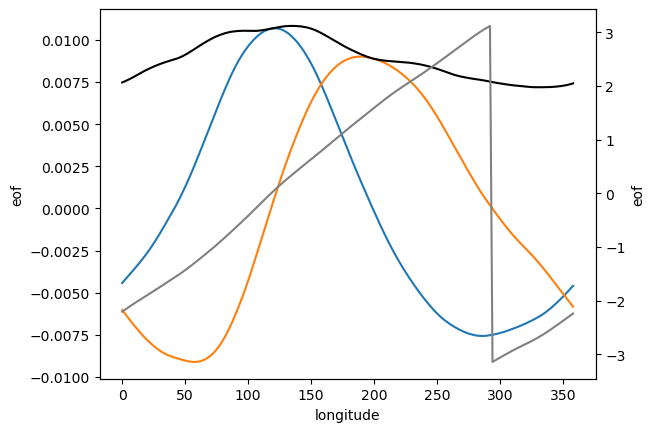

In [27]:
plot_polar(vpot_eof)

### Compare with Bureau of Meteorology figures
- http://www.bom.gov.au/climate/mjo/
- We multiply PC2 by -1, which gives a rotated version of the BoM figures.
- To align with orientation of BoM plots, multiply PC1, not PC2, by -1

In [28]:
pc1 = vpot_eof.pc.sel(mode=1)
pc2 = vpot_eof.pc.sel(mode=2) * -1

In [29]:
def plot_mjo(pc1, pc2, time_str, z_dim='time', phase=None):
    """
    Plot MJO progression
    """
    with plt.rc_context(plt_params):
        fig, ax = plt.subplots(1, 1, figsize=(4.9,4), dpi=150)

        ax.set_xlim(-1.7e9, 1.7e9)
        ax.set_ylim(-1.7e9, 1.7e9)
        ax.axvline(0, color='lightgray', zorder=0)
        ax.axhline(0, color='lightgray', zorder=0)
        ax.plot((-1.7e9, 1.7e9), (-1.7e9, 1.7e9), color='lightgray', zorder=0)
        ax.plot((-1.7e9, 1.7e9), (1.7e9, -1.7e9), color='lightgray', zorder=0)

        x = pc1.sel(time=time_str).values
        y = pc2.sel(time=time_str).values
        if z_dim == 'time':
            z = pd.to_datetime(pc1.sel(time=time_str).time.values).strftime('%Y-%m-%d')
            c = range(len(z))
        elif z_dim == 'phase':
            z = phase.sel(time=time_str).values
            c = z
        else:
            raise ValueError("z_dim should be 'time' or 'phase'")

        ax.plot(x, y, color='k', zorder=1)
        if z_dim == 'time':
            sc = ax.scatter(x, y, c=c, zorder=2, cmap='viridis')
        else:
            norm = matplotlib.colors.Normalize(vmin=-3.2, vmax=3.2)
            sc = ax.scatter(x, y, c=c, zorder=2, cmap='RdBu', norm=norm)
            
        ax.text(x[0]+0.1e9, y[0]+0.0e9, 'Start')
        ax.text(x[-1]-0.2e9, y[-1]+0.1e9, 'End')

        ax.set_xlabel(r'PC$_{1}$')
        ax.set_ylabel(r'PC$_{2}$')

        # The following octant labels were determined by comparing with figures from www.bom.gov.au/climate/mjo/
        ax.text(0.96, 0.75, '1', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.75, 0.95, '2', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.25, 0.95, '3', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.04, 0.75, '4', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.04, 0.25, '5', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.25, 0.05, '6', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.75, 0.05, '7', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.96, 0.25, '8', fontsize=plt_params['font.size']+7, ha='center', va='center', transform=ax.transAxes)

        ax.text(0.5, 0.96, 'Indian Ocean', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.04, 0.5, 'Maritime Continent', rotation=90, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.5, 0.04, 'Western Pacific', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.96, 0.5, 'W. Hem. and Africa', rotation=270, ha='center', va='center', transform=ax.transAxes)

        cb = fig.colorbar(sc)
        if z_dim == 'phase':
            cb.set_ticks(np.arange(-np.pi, np.pi+0.01, np.pi/4))
            cb.set_ticklabels([r'$-\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', '$0$',
                              r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
            cb.set_label(r'$\theta$')
        else:
            cb.set_ticks(c[::3])
            cb.set_ticklabels(z[::3])

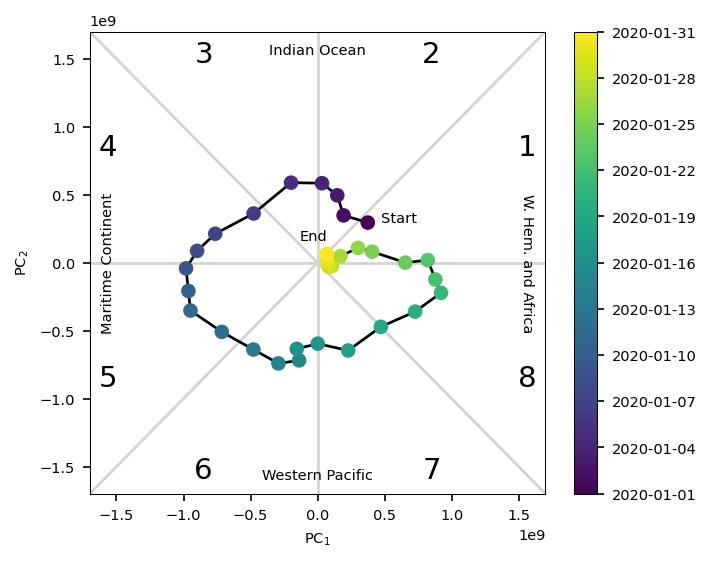

In [30]:
plot_mjo(pc1, pc2, '2020-01')

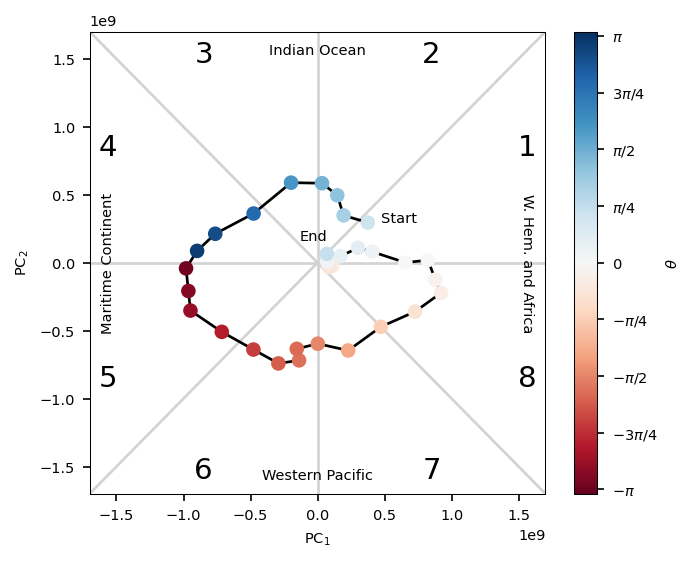

In [31]:
plot_mjo(pc1, pc2, '2020-01', z_dim='phase', phase=mjo.phase)

# Compute monthly MJO statistics

If we aggregate to monthly data then we can use existing codes to aggregate further to seasonal data needed for the coffee analysis.

Compute these statistics:
- Number of days in each phase per month
- Average magnitude of all days in each phase each month

In [32]:
def mjo_stats(mjo_ds, detrended=False):
    """
    Compute monthly statistics of MJO
    """
    if detrended:
        phase_ID_name = 'phase_ID_detrended'
        amplitude_name = 'amplitude_detrended'
    else:
        phase_ID_name = 'phase_ID'
        amplitude_name = 'amplitude'
    
    mjo_monthly = xr.Dataset()

    phase_dpm_list = []
    mean_amplitude_list = []

    for phase in range(1,9):

        phase_dpm_list.append(xr.where(mjo_ds[phase_ID_name] == phase, True, False) \
                              .resample(time='1MS').sum() \
                              .expand_dims({'phase_ID': [phase]}) \
                              .assign_coords({'phase_ID' : [phase]})
                      )
        mean_amplitude_list.append(mjo_ds[amplitude_name].where(mjo_ds[phase_ID_name] == phase) \
                                   .resample(time='1MS').mean() \
                                   .expand_dims({'phase_ID': [phase]}) \
                                   .assign_coords({'phase_ID': [phase]})
                                  )

    if detrended:
        mjo_monthly['mjo_days_per_month_detrended'] = xr.concat(phase_dpm_list, dim='phase_ID')
        mjo_monthly['mjo_mean_amplitude_detrended'] = xr.concat(mean_amplitude_list, dim='phase_ID')
    else:
        mjo_monthly['mjo_days_per_month'] = xr.concat(phase_dpm_list, dim='phase_ID')
        mjo_monthly['mjo_mean_amplitude'] = xr.concat(mean_amplitude_list, dim='phase_ID')
    
    return mjo_monthly

In [33]:
mjo_monthly = mjo_stats(mjo)

In [53]:
mjo_monthly.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_monthly_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022.nc',
    mode='w',
)

In [35]:
mjo_monthly_dt = mjo_stats(mjo_dt, detrended=True)

In [54]:
mjo_monthly_dt.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_monthly_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022_detrended.nc',
    mode='w',
)

# Also calculate anomalies

In [37]:
mjo_monthly_anoms = mjo_monthly.groupby('time.month').apply(lambda x: x - x.mean('time'))

In [55]:
mjo_monthly_anoms.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_monthly_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022.nc',
    mode='w'
)

In [39]:
mjo_monthly_dt_anoms = mjo_monthly_dt.groupby('time.month').apply(lambda x: x - x.mean('time'))

In [56]:
mjo_monthly_dt_anoms.to_netcdf(
    '/g/data/w42/dr6273/work/data/era5/climate_modes/mjo_monthly_anoms_clim_'+clim_period.start+'_'+clim_period.stop+'_1979-2022_detrended.nc',
    mode='w'
)

# Close cluster

In [73]:
client.close()
cluster.close()